# KH Temp Fire Modeling Notebook - Random Forest, Extra Trees

In [1]:
# Import libraries.
import boto3
import io
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score, accuracy_score, f1_score, make_scorer, precision_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from matplotlib import pyplot
import warnings
warnings.filterwarnings('ignore')

s3 = boto3.client('s3')

%config InlineBackend.figure_format = 'retina'

In [2]:
# Pull in cleaned and combined data from AWS 
noaa_on_fire = noaa_on_fire = pd.read_csv('s3://git-to-amazon-s3-outputbucket-rorni8oehk4l/soulclimberchick/meteorology-fire-impact/data-files/mfi_df_yr_trail.csv')
noaa_on_fire = pd.get_dummies(noaa_on_fire, columns=['state', 'month'], drop_first= True)

noaa_on_fire_btstrp = pd.concat([noaa_on_fire, 
                                 noaa_on_fire[noaa_on_fire['fire_size_class'] == 'C'].sample(n = 100000, replace = True, random_state=11),
                                 noaa_on_fire[noaa_on_fire['fire_size_class'] == 'D'].sample(n = 100000, replace = True, random_state=11),
                                 noaa_on_fire[noaa_on_fire['fire_size_class'] == 'E'].sample(n = 100000, replace = True, random_state=11),
                                 noaa_on_fire[noaa_on_fire['fire_size_class'] == 'F'].sample(n = 100000, replace = True, random_state=11),
                                 noaa_on_fire[noaa_on_fire['fire_size_class'] == 'G'].sample(n = 100000, replace = True, random_state=11)], axis = 0)

In [3]:
noaa_on_fire_btstrp.columns

Index(['Unnamed: 0', 'fire_code', 'fire_name', 'complex_name',
       'stat_cause_code', 'stat_cause_descr', 'fire_size', 'fire_size_class',
       'latitude', 'longitude', 'fips_code', 'cont_date_fixed',
       'disc_date_fixed', 'time_burnt', 'year', 'yearmonth', 'pcp', 'tavg',
       'pdsi', 'phdi', 'zndx', 'pmdi', 'cdd', 'hdd', 'sp01', 'sp02', 'sp03',
       'sp06', 'sp09', 'sp12', 'sp24', 'tmin', 'tmax', 'tavg_t3m', 'tavg_t6m',
       'tavg_t9m', 'tavg_t12m', 'pcp_t3m', 'pcp_t6m', 'pcp_t9m', 'pcp_t12m',
       'pmdi_t3m', 'pmdi_t6m', 'pmdi_t9m', 'pmdi_t12m', 'pdsi_t3m', 'pdsi_t6m',
       'pdsi_t9m', 'pdsi_t12m', 'state_CA', 'state_CO', 'state_ID', 'state_MT',
       'state_NM', 'state_NV', 'state_OR', 'state_UT', 'state_WA', 'state_WY',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12'],
      dtype='object')

In [4]:
# Set up X and y variables, and bootstrap data

X_vars = ['state_CA', 'state_CO', 'state_ID',
       'state_MT', 'state_NM', 'state_NV', 'state_OR', 'state_UT', 'state_WA',
       'state_WY', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12','tavg_t12m',
       'tavg_t9m', 'tavg_t6m', 'tavg_t3m', 'pcp_t12m', 'pcp_t9m', 'pcp_t6m',
       'pcp_t3m', 'pmdi_t12m', 'pmdi_t9m', 'pmdi_t6m', 'pmdi_t3m', 'pdsi_t12m',
       'pdsi_t9m', 'pdsi_t6m', 'pdsi_t3m', 'zndx', 'cdd', 'hdd']

noaa_on_fire_btstrp = noaa_on_fire.dropna(subset = X_vars)


X = noaa_on_fire_btstrp[X_vars]
y = noaa_on_fire_btstrp['fire_size_class']

In [5]:
# Train Test Split and scale data
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y)

stan = StandardScaler()
X_train = stan.fit_transform(X_train)
X_test = stan.transform(X_test)

In [6]:
# What is the accuracy of our baseline model?
y.value_counts(normalize=True)

A    0.613502
B    0.290010
C    0.055196
D    0.015331
E    0.011383
F    0.009211
G    0.005367
Name: fire_size_class, dtype: float64

In [7]:
# Instantiate simple RandomForestClassifier and ExtraTreesClassifier objects.
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
et = ExtraTreesClassifier(n_estimators=100, n_jobs=-1)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [8]:
# Fit and score on the training data.
cross_val_score(rf, X_train, y_train, cv=5).mean()

0.6202172203890196

In [9]:
# Fit and score on the training data.
cross_val_score(et, X_train, y_train, cv=5).mean()

0.620526483810019

In [10]:
# Score on the testing data.
rf.score(X_test, y_test)

0.6206628224824917

In [11]:
# Calculate Recall Score on random forest
recall_score(y_train, rf.predict(X_train), average = 'weighted')

0.6267616406286372

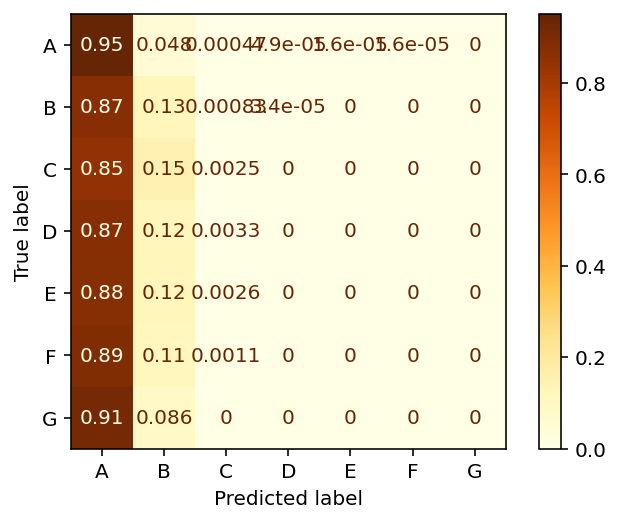

In [12]:
# Plot random forest confusion matrix
plot_confusion_matrix(rf, X_test, y_test, cmap = 'YlOrBr', normalize= 'true');

## More Advanced Random Forest Classifier

In [13]:
# instantiate Validation Curve to evaluate estimators of the models
num_est=[100, 200, 300]
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = X_train, y = y_train, 
                                param_name = 'n_estimators', 
                                param_range = num_est, cv = 3,
                                n_jobs=-1)

Feature: 0, Score: 0.00644
Feature: 1, Score: 0.04104
Feature: 2, Score: 0.00690
Feature: 3, Score: 0.00379
Feature: 4, Score: 0.01229
Feature: 5, Score: 0.00409
Feature: 6, Score: 0.04923
Feature: 7, Score: 0.00579
Feature: 8, Score: 0.00235
Feature: 9, Score: 0.02509
Feature: 10, Score: 0.00109
Feature: 11, Score: 0.00608
Feature: 12, Score: 0.01179
Feature: 13, Score: 0.00852
Feature: 14, Score: 0.00739
Feature: 15, Score: 0.00359
Feature: 16, Score: 0.00247
Feature: 17, Score: 0.00157
Feature: 18, Score: 0.00130
Feature: 19, Score: 0.00094
Feature: 20, Score: 0.00081
Feature: 21, Score: 0.06354
Feature: 22, Score: 0.04049
Feature: 23, Score: 0.05193
Feature: 24, Score: 0.08410
Feature: 25, Score: 0.04147
Feature: 26, Score: 0.04020
Feature: 27, Score: 0.03106
Feature: 28, Score: 0.03188
Feature: 29, Score: 0.04611
Feature: 30, Score: 0.03568
Feature: 31, Score: 0.03231
Feature: 32, Score: 0.03095
Feature: 33, Score: 0.04556
Feature: 34, Score: 0.03421
Feature: 35, Score: 0.03150
Fe

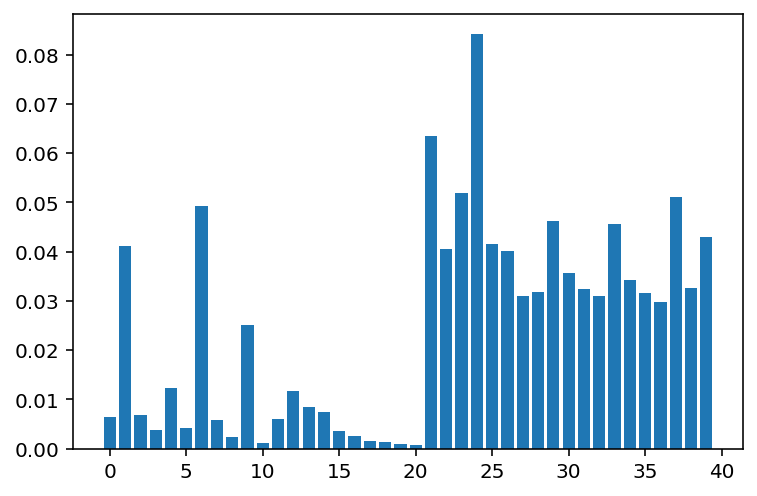

In [14]:
# Instantiate Random Forest Classifier 
forestVC = RandomForestClassifier(random_state = 1,
                                  n_estimators = 750,
                                  max_depth = 15, 
                                  min_samples_split = 5,  
                                  min_samples_leaf = 1, 
                                  n_jobs=-1) 
modelVC = forestVC.fit(X_train, y_train) 
y_predVC = modelVC.predict(X_test)

importance = modelVC.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [15]:
# # Set up parameters to grid search over - Keep Me!
# n_estimators = [100, 300, 500]
# max_depth = [5, 8, 15, 25, 30]
# min_samples_split = [2, 5, 10, 15, 50]
# min_samples_leaf = [1, 2, 5, 10] 

# hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
#               min_samples_split = min_samples_split, 
#              min_samples_leaf = min_samples_leaf)

# gridF = GridSearchCV(rf, hyperF, cv = 3, verbose = 1, 
#                       n_jobs = -1)
# bestF = gridF.fit(X_train, y_train)

In [16]:
# # List best features score
# bestF.best_score_

In [17]:
# # List best parameters
# bestF.best_params_

Feature: 0, Score: 0.00613
Feature: 1, Score: 0.03828
Feature: 2, Score: 0.00676
Feature: 3, Score: 0.00396
Feature: 4, Score: 0.01449
Feature: 5, Score: 0.00434
Feature: 6, Score: 0.04497
Feature: 7, Score: 0.00504
Feature: 8, Score: 0.00276
Feature: 9, Score: 0.03013
Feature: 10, Score: 0.00074
Feature: 11, Score: 0.00533
Feature: 12, Score: 0.01198
Feature: 13, Score: 0.00852
Feature: 14, Score: 0.00779
Feature: 15, Score: 0.00326
Feature: 16, Score: 0.00241
Feature: 17, Score: 0.00181
Feature: 18, Score: 0.00113
Feature: 19, Score: 0.00066
Feature: 20, Score: 0.00067
Feature: 21, Score: 0.06443
Feature: 22, Score: 0.04205
Feature: 23, Score: 0.04769
Feature: 24, Score: 0.08266
Feature: 25, Score: 0.04225
Feature: 26, Score: 0.03938
Feature: 27, Score: 0.03072
Feature: 28, Score: 0.03298
Feature: 29, Score: 0.04537
Feature: 30, Score: 0.03657
Feature: 31, Score: 0.03072
Feature: 32, Score: 0.03168
Feature: 33, Score: 0.04301
Feature: 34, Score: 0.03351
Feature: 35, Score: 0.03562
Fe

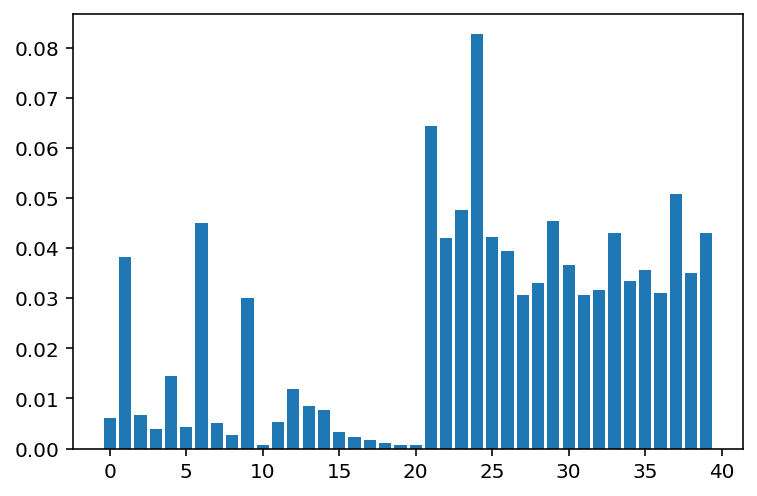

In [18]:
# Run the model with the best params from the grid search
forestOpt = RandomForestClassifier(random_state = 11, max_depth = 15, n_estimators = 100, min_samples_split = 10, min_samples_leaf = 10, n_jobs=-1)                             
modelOpt = forestOpt.fit(X_train, y_train)
y_pred = modelOpt.predict(X_test)

importance = modelOpt.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [19]:
# List recall score
recall_score(y_train, modelOpt.predict(X_train), average = 'weighted')

0.6255511881721503

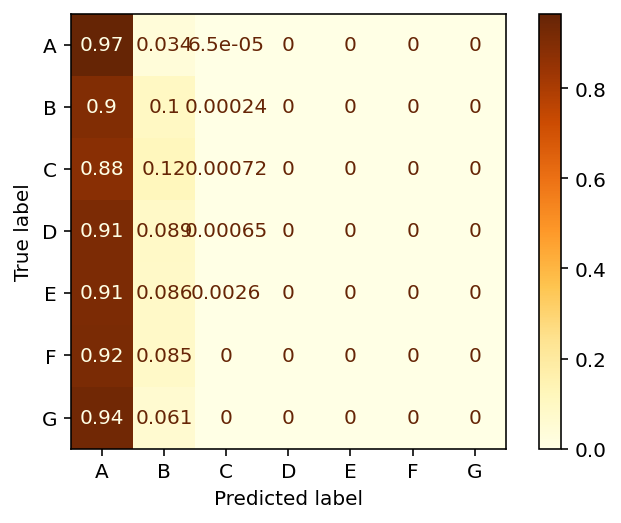

In [20]:
# Plot a confusion matrix
plot_confusion_matrix(modelOpt, X_test, y_test, cmap = 'YlOrBr', normalize= 'true');

In [ ]:
# Let's scoop lat/long up in a matrix so we can use them easily
location_data = round(noaa_on_fire_btstrp[['longitude', 'latitude']],4) # round to decrease grid accuracy of lat/long

# Let's cluster our observations by lat/long: how many clusters should we use?
km = KMeans(n_clusters=200)
km.fit(location_data)

# Append these clusters back onto model_df
noaa_on_fire_btstrp.loc[:, 'cluster'] = km.predict(location_data)